In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [7]:
from utilities.userfold_framework import *
# from utilities.EEG_func import *
import Models.model_func as Model_Func
from Models.AR_EEG_models import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
from torch import nn


DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]
for r in [4]:
    for i in range(len(participants)):

        train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                          raw_user_fold,
                                                                                          participants,
                                                                                          batch_size=batch_size,
                                                                                          transpose_channels=transpose_channels)

        classifier= EEGNet(
            chunk_size=input_dim[1],
            num_electrodes=input_dim[0],
            num_classes=classes,
            kernel_1= 32,
            kernel_2=32,
            F1=8,
            F2=16,
            dropout=0.5
        ).to(DEVICE)

    #     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
    #     softmax_activation = nn.LogSoftmax(dim=1)
    #     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)


    #     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
    #     classifier.to(DEVICE)

    #     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)


        criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    #     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))


        saved_dir= f"./EEG/saved_models/Userfold/run{r}"
    #     model= Multivariate_IEGradient(DEVICE, input_dim, resnet_classifier).to(DEVICE)
        model= LSTM_EEGNet_Wrapper(DEVICE, classifier, input_dim).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

#         train_func= eeg_train
#         model.training_procedure(iteration=n_epochs,
#                                         train_dataloader=train_dataloader,
#                                          val_dataloader=val_dataloader,
#                                          print_cycle=2,
#                                          path=f"./dictionary/intermdiate_dicts",
#                                          loss_func=criterion,
#                                          optimiser=optimizer, #scheduler=scheduler,
#                                          train_func=train_func
#                                         )
#         if model.epoch == n_epochs+1:
#             EPOCH= n_epochs
#         else:
#             EPOCH= model.epoch

#         torch.save(model.state_dict(), 
#                os.path.join(
#                    saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-Baseline-e{EPOCH}.pt"
#                )
#         )

    # OR
        model.load_state_dict(
        torch.load(
            open(
                os.path.join(
                    saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-Baseline-e{n_epochs}.pt"
                ), "rb"
            )
                  )
        )


        prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)

        ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])

        c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
        print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
        b_acc_list.append(b_acc)
        c0_acc_list.append(c0_acc)
        c1_acc_list.append(c1_acc)
        participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


103 20

c0_acc 0.9279279279279279 , c1_acc 0.4 , b_acc 0.663963963963964
109 11

c0_acc 0.9478260869565217 , c1_acc 0.20754716981132076 , b_acc 0.5776866283839213
112 12

c0_acc 0.9105691056910569 , c1_acc 0.22641509433962265 , b_acc 0.5684921000153398
120 11

c0_acc 0.916030534351145 , c1_acc 0.19642857142857142 , b_acc 0.5562295528898582
108 13

c0_acc 0.9230769230769231 , c1_acc 0.2653061224489796 , b_acc 0.5941915227629514
115 2

c0_acc 0.92 , c1_acc 0.04 , b_acc 0.48000000000000004
111 15

c0_acc 0.888 , c1_acc 0.26785714285714285 , b_acc 0.5779285714285715
120 4

c0_acc 0.9523809523809523 , c1_acc 0.06779661016949153 , b_acc 0.510088781275222
124 15

c0_acc 0.9323308270676691 , c1_acc 0.2727272727272727 , b_acc 0.6025290498974709
126 10

c0_acc 0.9767441860465116 , c1_acc 0.1694915254237288 , b_acc 0.5731178557351202
113 7

c0_acc 0.9495798319327731 , c1_acc 0.14583333333333334 , b_acc 0.5477065826330532
118 25

c0_acc 0.9672131147540983 , c1_acc 0.46296296296296297 , b_acc 0.715

     accuracy  f1-score
S01  0.763975  0.741330
S02  0.714286  0.660150
S03  0.704545  0.662289
S04  0.700535  0.652466
S05  0.728916  0.691393
S06  0.668571  0.588870
S07  0.696133  0.662681
S08  0.670270  0.580031
S09  0.739362  0.701826
S10  0.723404  0.655974
S11  0.718563  0.655864
S12  0.812500  0.792975
S13  0.737430  0.689827
S14  0.674033  0.614640
S15  0.672131  0.614828
S16  0.683060  0.593298
S17  0.734940  0.701731
S19  0.701087  0.650223
S20  0.761111  0.723849


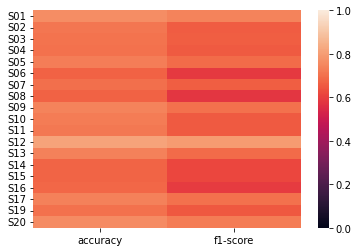

     class0 f1-score  class1 f1-score
S01         0.844262         0.512821
S02         0.819549         0.314286
S03         0.811594         0.315789
S04         0.810811         0.282051
S05         0.827586         0.366197
S06         0.798611         0.064516
S07         0.801444         0.352941
S08         0.797342         0.115942
S09         0.835017         0.379747
S10         0.828947         0.277778
S11         0.827839         0.229508
S12         0.877323         0.602410
S13         0.833922         0.373333
S14         0.794425         0.213333
S15         0.793103         0.210526
S16         0.807947         0.093750
S17         0.829457         0.405405
S19         0.809689         0.303797
S20         0.848057         0.441558


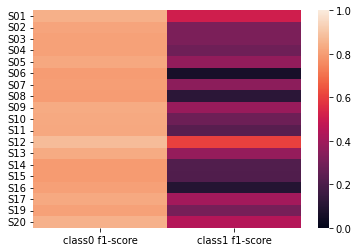

In [8]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)
